In [1]:
# This notebook uses creates a subset of 'Married'&Singles' of the Taiwan Credit Default dataset. 
# Import Data handling/display libraries
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.base            import TransformerMixin
from sklearn.pipeline        import Pipeline, FeatureUnion
from sklearn.preprocessing   import LabelEncoder,StandardScaler, MinMaxScaler, RobustScaler 
from typing                  import List, Union, Dict
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the Taiwan Credit Card Default training dataset
Taiwan_df = pd.read_csv('./input/Taiwan-Credit-Card-Default.csv')

# Drop the first row because it is a redundant heading row.
Taiwan_df.to_csv('./input/Taiwan-Credit-Card-New.csv', header=False, index=False)

# Re-read the dataset with its proper column headers
Taiwan_df = pd.read_csv('./input/Taiwan-Credit-Card-New.csv')
Taiwan_df.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [3]:
# Create MARRIED & SINGLE subset of the dataset
Taiwan_df = Taiwan_df.loc[(Taiwan_df['MARRIAGE'] ==1) | (Taiwan_df['MARRIAGE'] ==2)]

In [4]:
Taiwan_df.shape

(29623, 25)

In [5]:
# Rename a couple of columns for aesthetics
Taiwan_df.rename(columns={'SEX':'GENDER', 'PAY_0': 'PAY_1',
                          'default payment next month':'DEFAULT'}, inplace=True)
# Drop ID as it has no impact on this study.
Taiwan_df.drop(["ID"], axis=1, inplace=True)

In [6]:
# This step is omitted because changing MARRIAGE values impacted feature importance!!
# This step made Marriage value: Singles 0, Married 1 (Originally they were Singles 2, Married 1)
#print('Before MARRIAGE transform:')
#print(Taiwan_df.MARRIAGE.value_counts())
#marriage = {1: 1,2: 0} 
#Taiwan_df.MARRIAGE = [marriage[item] for item in Taiwan_df.MARRIAGE]
#print('After MARRIAGE transform:')
#print(Taiwan_df.MARRIAGE.value_counts())

In [7]:
# Encode DEFAULT from non-default=0 and default=1 ==> non-default=1, default=0
# to comply with the AIF360 hard coded values for favourable/unfavavourable labels. 
#print('Before DEFAULT transform:')
#print(Taiwan_df.DEFAULT.value_counts())
#default = {1: 0,0: 1}
#Taiwan_df.DEFAULT = [default[item] for item in Taiwan_df.DEFAULT]
#print('Before DEFAULT transform:')
#print(Taiwan_df.DEFAULT.value_counts())

In [8]:
# Marrieds are 1s, Singles are 2s.
Taiwan_df.groupby(['MARRIAGE', 'DEFAULT']).size()

MARRIAGE  DEFAULT
1         0          10453
          1           3206
2         0          12623
          1           3341
dtype: int64

In [9]:
# Make males 1, Females 0 - this is in case we want to make GENDER the protected attribute
#print('Before GENDER transform:')
#print(Taiwan_df.GENDER.value_counts())
#gender = {1: 1,2: 0}
#Taiwan_df.GENDER = [gender[item] for item in Taiwan_df.GENDER]
#print('Before GENDER transform:')
#print(Taiwan_df.GENDER.value_counts())

In [10]:
# Clean up the EDUCATION values
# Education categories 0, 5, and 6 have no definition, make them 'Education Other',eg '4'
fil = (Taiwan_df.EDUCATION == 5) | (Taiwan_df.EDUCATION == 6) | (Taiwan_df.EDUCATION == 0)
Taiwan_df.loc[fil, 'EDUCATION'] = 4

In [11]:
#Create new column AMT_PAY_RATIO = Total sum owed / Total sum paid over 6 months
Taiwan_df['AMT_PAY_RATIO'] = (Taiwan_df['BILL_AMT1']+Taiwan_df['BILL_AMT2']+
                              Taiwan_df['BILL_AMT3']+Taiwan_df['BILL_AMT4']+
                              Taiwan_df['BILL_AMT5']+
                              Taiwan_df['BILL_AMT6']) / (Taiwan_df['PAY_AMT1']+
                                                         Taiwan_df['PAY_AMT2']+Taiwan_df['PAY_AMT3']+
                                                         Taiwan_df['PAY_AMT4']+Taiwan_df['PAY_AMT5']+
                                                         Taiwan_df['PAY_AMT6'])  

In [12]:
# Here we create a 6 new columns called AMT-PAY-RATIO. This will contain 
# the amount/payment ratio for the 6 BILL_AMTx/PAY_AMTx. 
Taiwan_df['AMT_PAY_RATIO1'] = Taiwan_df['BILL_AMT1']/Taiwan_df['PAY_AMT1']
Taiwan_df['AMT_PAY_RATIO2'] = Taiwan_df['BILL_AMT2']/Taiwan_df['PAY_AMT2']
Taiwan_df['AMT_PAY_RATIO3'] = Taiwan_df['BILL_AMT3']/Taiwan_df['PAY_AMT3']
Taiwan_df['AMT_PAY_RATIO4'] = Taiwan_df['BILL_AMT4']/Taiwan_df['PAY_AMT4']
Taiwan_df['AMT_PAY_RATIO5'] = Taiwan_df['BILL_AMT5']/Taiwan_df['PAY_AMT5']
Taiwan_df['AMT_PAY_RATIO6'] = Taiwan_df['BILL_AMT6']/Taiwan_df['PAY_AMT6']

# We now replace the inf values (from division by zero) with NaN
Taiwan_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
# Create a function to return columns from the dataframe.
class SelectCols(TransformerMixin):
    """Select columns from a DataFrame."""
    def __init__(self, cols: List[str]) -> None:
        self.cols = cols
    def fit(self, x: None) -> "SelectCols":
        """Nothing to do."""
        return self
    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """Return just selected columns."""
        return x[self.cols]

In [14]:
class NumericEncoder(TransformerMixin):
    """Remove invalid values from numerical columns, replace with median."""
    def fit(self, x: pd.DataFrame) -> "NumericEncoder":
        # Find median for all columns. Examine all columns for non-NaNs, invalid values and NaNs
        # If a column is all NaNs (after coercion), the median value will be a NaN.
        self.encoders_ = {
            c: pd.to_numeric(x[c], errors='coerce').median(skipna=True) for c in x}
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        #For each column in x, encode any NaN values with the learned medium 
        # Create a list of new DataFrames, each with 1 cleaned columns
        output_dfs = []
        for c in x:
            new_cols = pd.DataFrame()
            # Find invalid values that aren't nans (-inf, inf, string)
            invalid_idx = pd.to_numeric(x[c].replace([-np.inf, np.inf],np.nan),
                                        errors='coerce').isnull()
            # Copy to new df for this column
            new_cols.loc[:, c] = x[c].copy()
            # Replace the invalid values with learned median
            new_cols.loc[invalid_idx, c] = self.encoders_[c]
            output_dfs.append(new_cols)

        # Concat list of output_dfs to single df
        df = pd.concat(output_dfs, axis=1)
        # Return with an remaining NaNs removed. These might exist if the median
        # is a NaN because there was no numeric data in the column at all.
        return df.fillna(0)

In [15]:
# Determine what columns go into the cleaned dataset

# This code includes the calculated ratios in the cleaned dataset
#pp_numeric_cols = Pipeline([('select', SelectCols(cols=['LIMIT_BAL','GENDER','EDUCATION','MARRIAGE','AGE',
#                                                       'PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
#                                                       'AMT_PAY_RATIO1', 'AMT_PAY_RATIO2', 'AMT_PAY_RATIO3', 
#                                                       'AMT_PAY_RATIO4', 'AMT_PAY_RATIO5', 'AMT_PAY_RATIO6',
#                                                       'AMT_PAY_RATIO', 'DEFAULT'])),
#                            ('process', NumericEncoder())])

# This code includes all original Taiwan columns in the cleaned dataset
pp_numeric_cols = Pipeline([('select', SelectCols(cols=['LIMIT_BAL','GENDER','EDUCATION','MARRIAGE','AGE',
                                                        'PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
                                                        'BILL_AMT1','BILL_AMT2','BILL_AMT3', 
                                                        'BILL_AMT4','BILL_AMT5','BILL_AMT6',
                                                        'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4', 
                                                        'PAY_AMT5','PAY_AMT6', 'DEFAULT'])),
                            ('process', NumericEncoder())])
# fit_transform on the Taiwan dataset
Taiwan_pp = pp_numeric_cols.fit_transform(Taiwan_df)

In [16]:
# Test step - 
# Drop various columns to see whether we get meaningful results in de-biasing.
#Taiwan_pp.drop(["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"], axis=1, inplace=True)
#Taiwan_pp.drop(["EDUCATION"], axis=1, inplace=True)
#Taiwan_pp.drop(["AGE"], axis=1, inplace=True)
#Taiwan_pp.drop(["GENDER"], axis=1, inplace=True)
#Taiwan_pp.drop(["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"], axis=1, inplace=True)
#Taiwan_pp.drop(["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"], axis=1, inplace=True)
#Taiwan_pp.drop(["AMT_PAY_RATIO1","AMT_PAY_RATIO2", "AMT_PAY_RATIO3", "AMT_PAY_RATIO4", "AMT_PAY_RATIO5", "AMT_PAY_RATIO6"], axis=1, inplace=True)
#Taiwan_pp.drop(["LIMIT_BAL"], axis=1, inplace=True)
#Taiwan_pp.drop(["AMT_PAY_RATIO"], axis=1, inplace=True)
#Taiwan_pp.drop(["AGE"], axis=1, inplace=True)

Taiwan_pp.head(5)

,LIMIT_BAL,GENDER,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0


In [17]:
# Finally write the cleaned dataset out to a csv
Taiwan_pp.to_csv('./input/Taiwan-Credit-Card-Cleaned-Marriage.csv',index=False)

In [18]:
## NOW DETERMINE THE MOST IMPORTANT FEATURES OF A RANDOM FOREST CLASSIFIER

In [19]:
Taiwan_df = pd.read_csv('./input/Taiwan-Credit-Card-Cleaned-Marriage.csv')
X = Taiwan_df.drop("DEFAULT",axis=1)
y = Taiwan_df["DEFAULT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [20]:
# Scale the Test and Train dataframes 
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(copy=False)
#X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
#X_test  = pd.DataFrame(scaler.fit_transform(X_test.values),  columns=X_test.columns,  index=X_test.index)

In [21]:
biasedlogmodel = LogisticRegression(random_state=101)
biasedlogmodel.fit(X_train,y_train)
logpredictions = biasedlogmodel.predict(X_test)
print(f"Logistic regression validation accuracy: {biasedlogmodel.score(X_test, y_test)}")

Logistic regression validation accuracy: 0.7714767932489451


In [22]:
biasedrfcmodel = RandomForestClassifier(n_estimators=100,max_depth=4)
biasedrfcmodel.fit(X_train, y_train)
rfcpredictions = biasedrfcmodel.predict(X_test)
print(f"Random forest validation accuracy: {biasedrfcmodel.score(X_test, y_test)}")

Random forest validation accuracy: 0.8087763713080168


In [23]:
## THIS IS MY CODE TO DISPLAY FEATURE IMPORTANCE
# List feature importances from the Random Forest Classifier
feature_importances = pd.DataFrame(biasedrfcmodel.feature_importances_, index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
PAY_1,0.339339
PAY_2,0.192891
PAY_3,0.128280
PAY_4,0.072504
PAY_5,0.057627
PAY_6,0.046203
PAY_AMT1,0.037009
LIMIT_BAL,0.027330
PAY_AMT2,0.020850
PAY_AMT3,0.019118


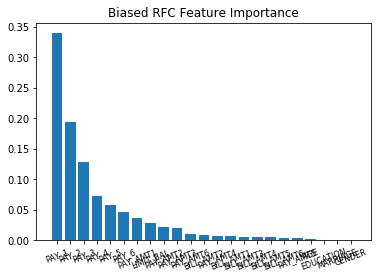

In [24]:
## THIS IS MY CODE TO DISPLAY FEATURE IMPORTANCE
# Display feature importances from the Random Forest Classifier
feature_names = list(Taiwan_df.columns)

importances = biasedrfcmodel.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
 
# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=20, fontsize = 8)
# Create plot title
plt.title("Biased RFC Feature Importance")
# Show plot
plt.show()

In [25]:
## THIS IS GARETH's CODE TO DISPLAY FEATURE IMPORTANCE
# Check for the attribute with the most impact on a random forest classification
def feature_importance(mod: Union[LogisticRegression,RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names,'importance': imp,
                         'std': var}).sort_values('importance',ascending=False)
def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

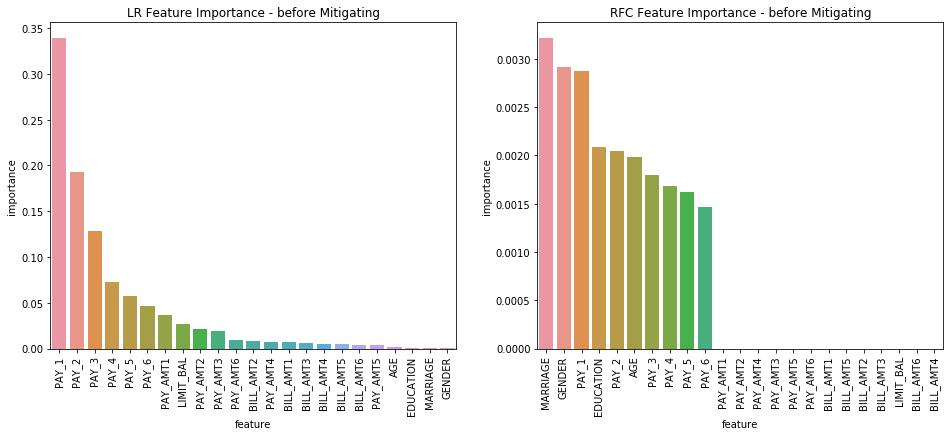

In [26]:
## THIS IS GARETH's CODE TO DISPLAY FEATURE IMPORTANCE
## THE RFC CHART (bottom right) DIFFERS FROM MINE IN CELL 22 & 23
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biasedlogmodel,
                                                names=X_train.columns.tolist(),
                                                scale=X_train.std()),
                       ax=ax[1])
_ = ax[0].set_title('LR Feature Importance - before Mitigating')
plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biasedrfcmodel,
                                                names=X_train.columns.tolist()),
                       ax=ax[0])
_ = ax[1].set_title('RFC Feature Importance - before Mitigating')